In [17]:

# LOADING REQUIRED PACKAGES
import pickle
from collections import Counter
import itertools
import json
import powerlaw
from kneed import KneeLocator
import pickle

# NetworkX and Seaborn
from networkx.algorithms import bipartite
import seaborn as sns
from collections import defaultdict

# === Third-Party Libraries ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.ticker import ScalarFormatter
from matplotlib.patches import Patch

import matplotlib.ticker as ticker 

from adjustText import adjust_text
import networkx as nx
from networkx.algorithms import bipartite
import community as community_louvain  # Louvain community detection (python-louvain)
import textwrap
# Optional: Configure matplotlib to use a specific style or suppress warnings
# plt.style.use('seaborn-whitegrid')  # optional, if you want a consistent style

from powerlaw import Fit 
from mpmath import zeta as mpzeta
from scipy.optimize import minimize_scalar




powerlaw.__version__  # Check the version of powerlaw package

'1.4.4'

In [18]:
# LOADING THE UNIPARTITE taxa _species PROJECTION NETWORK
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/network_analysis/bipartite_species_network.gpickle", "rb") as f:
    B_species = pickle.load(f)

In [19]:
# Open the JSON file containing taxa name mappings
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/gut_microbiome_project/resources/taxon_dict.json", "r") as f:
    taxon_dict = json.load(f)

# Load the phenotype mapping JSON
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/resources/taxon_phyla_dict.json", "r") as f:
    taxa_category_by_id = json.load(f)

In [20]:
# Get only the taxa nodes (bipartite = 0)
taxa_nodes = {n for n, t in B_species.nodes(data=True) if t.get("bipartite") == 1}

# Check taxa nodes
if not taxa_nodes:
    raise ValueError("No taxa nodes with bipartite==0 found in B_species.")

# Build weighted taxa–taxa projection (weight = shared taxa count)
U_taxa_species = bipartite.weighted_projected_graph(B_species, taxa_nodes)

# --- Labels from taxa_dict ---
labels = {n: taxon_dict.get(n, str(n)) for n in U_taxa_species.nodes()}


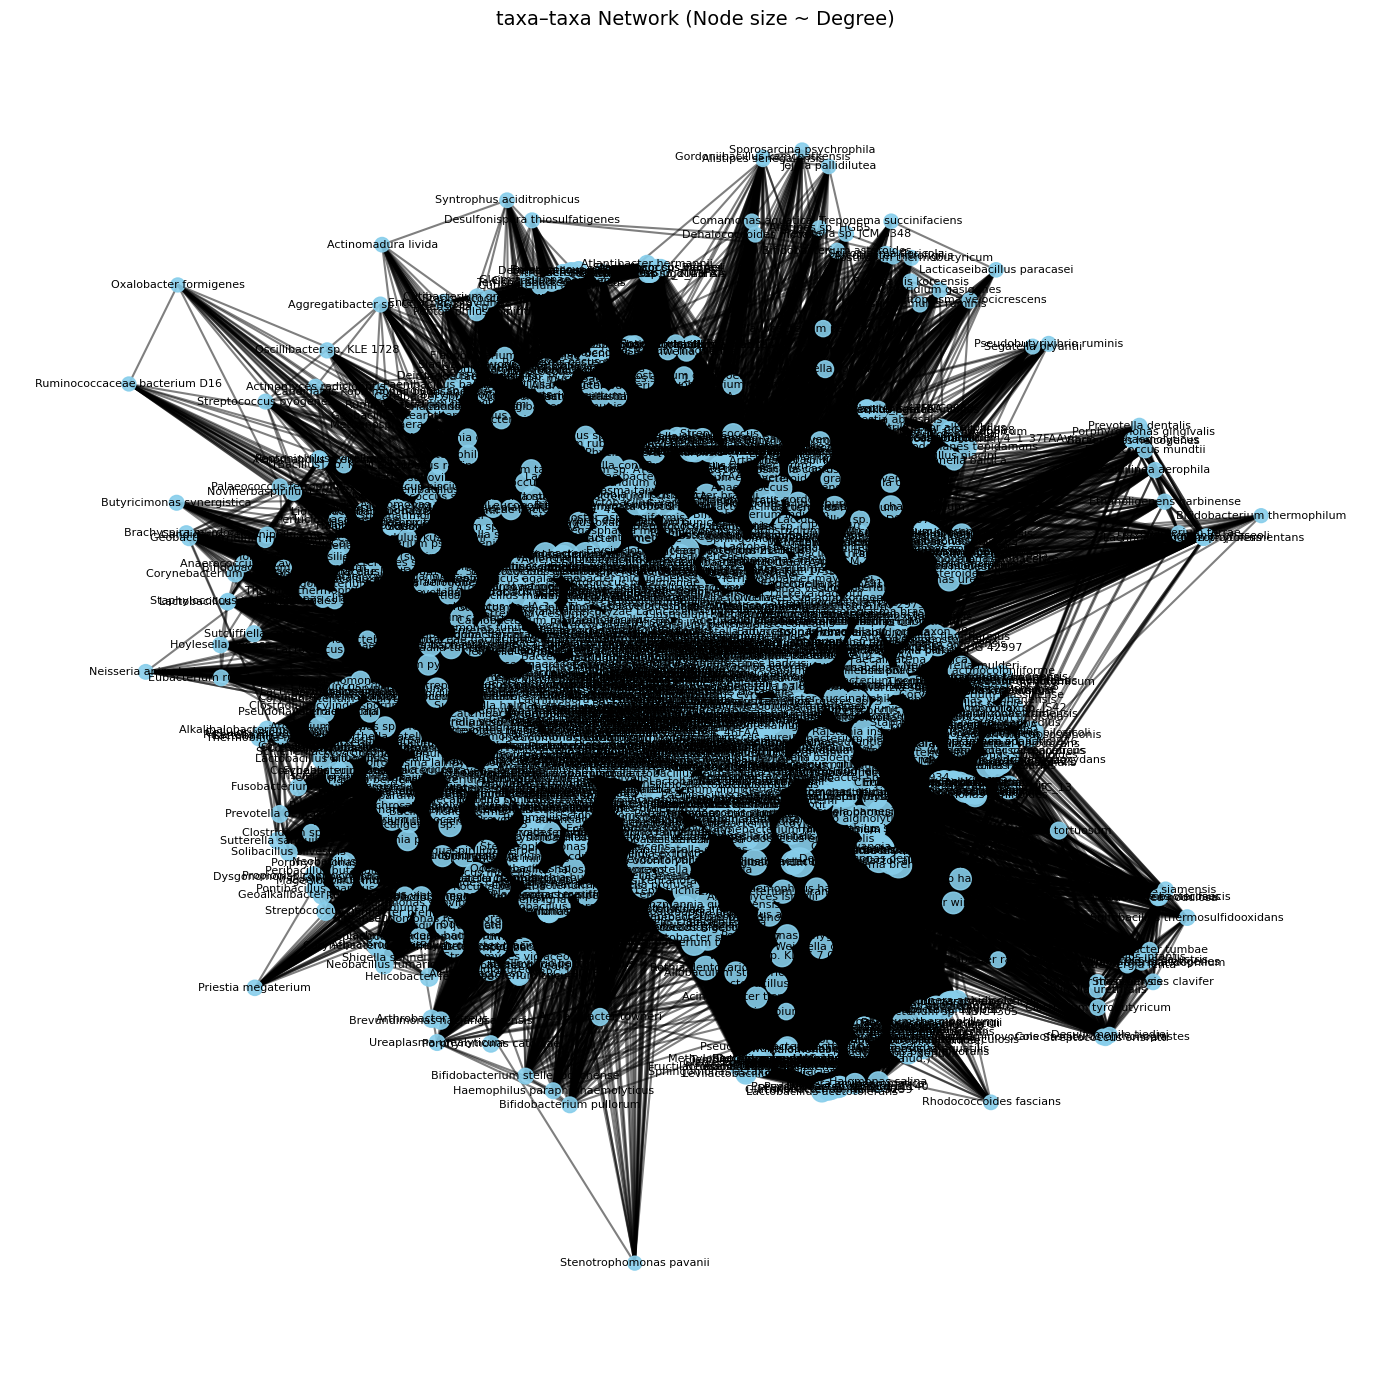

In [21]:

# --- Filter edges by minimum weight ---
min_weight = 0  # Change as needed
edges_to_keep = [(u, v) for u, v, d in U_taxa_species.edges(data=True) if d.get("weight", 1) >= min_weight]
U_filtered = U_taxa_species.edge_subgraph(edges_to_keep).copy()

# --- Generate layout ---
pos = nx.spring_layout(U_filtered, seed=42)

# --- Get degrees and scale node sizes ---
degrees = dict(U_filtered.degree())
min_size, max_size = 100, 700  # Pixel range for node sizes
deg_vals = list(degrees.values())
if deg_vals:
    dmin, dmax = min(deg_vals), max(deg_vals)
    # Normalize degrees to [0,1]
    deg_norm = [(deg - dmin) / (dmax - dmin) if dmax != dmin else 1.0 for deg in deg_vals]
    node_sizes = [min_size + norm * (max_size - min_size) for norm in deg_norm]
else:
    node_sizes = [min_size for _ in degrees]

# --- Draw nodes with degree-based sizes ---
plt.figure(figsize=(14, 14))
nx.draw_networkx_nodes(U_filtered, pos, node_size=node_sizes, node_color="skyblue", alpha=0.9)

# --- Draw edges with weight-based width ---
edge_weights = [d['weight'] for _, _, d in U_filtered.edges(data=True)]
nx.draw_networkx_edges(U_filtered, pos, width=[0.5 + w for w in edge_weights], alpha=0.5)

# --- Draw labels ---
labels = {n: taxon_dict.get(n, str(n)) for n in U_filtered.nodes()}
nx.draw_networkx_labels(U_filtered, pos, labels=labels, font_size=8)

# --- Final touches ---
plt.title("taxa–taxa Network (Node size ~ Degree)", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()




---

## POWER LAW DISTRIBUTION

### 1. `_empirical_ccdf(data)`

**Purpose**:
Computes the **empirical complementary cumulative distribution function (CCDF)** for the input data.
This shows the probability $P(X \geq x)$, i.e., the fraction of data points that are greater than or equal to each unique value.

**Use case**:
To visualize the **tail behavior** of a degree distribution on a log–log scale for power-law fitting.

---

### 2. `discrete_ccdf_model(xs, xmin, alpha)`

**Purpose**:
Generates the **theoretical CCDF** of a discrete power-law distribution using the **Hurwitz zeta function**.
The CCDF is calculated as:

$$
P(K \geq k) = \frac{\zeta(\alpha, k)}{\zeta(\alpha, x_{\min})}
$$

where $\zeta$ is the Hurwitz zeta function.

**Use case**:
To overlay the **fitted power-law model curve** on top of the empirical CCDF and assess the quality of fit.

---

### 3. `fit_powerlaw_degree_tail_discrete(...)`

**Purpose**:
Fits a **discrete power-law** to the **tail** of a distribution using **maximum likelihood estimation (MLE)** and **Kolmogorov–Smirnov (KS) distance** minimization.

**Main steps**:

* Iterates over candidate `xmin` values
* For each, computes the MLE of `alpha` (scaling exponent)
* Compares the model CDF to empirical CDF using KS distance
* Selects the best-fitting parameters (lowest KS)

**Returns**: A dictionary with:

* `pl_xmin`: Best xmin cutoff where the power-law tail starts
* `pl_alpha`: Estimated exponent (α)
* `pl_ks`: KS distance between empirical and model CDF
* `pl_n_tail`: Number of values in the tail
* `pl_tail_prop`: Tail size as a proportion of total data

**Use case**:
Robust and accurate fitting of **power-law behavior** in **discrete data** (like degree distributions in networks), especially suitable for biological or real-world network analyses.

---




## LOG NORMAL DISTRIBUTION
---

To evaluate the statistical properties of the degree distribution in the taxa–taxa network, I fitted a log-normal distribution using maximum likelihood estimation (MLE). The log-normal model assumes that the logarithm of the degree values $k$ follows a normal distribution, i.e., $\log(k) \sim \mathcal{N}(\mu, \sigma^2)$, which implies the probability density function (PDF) of the degree is given by:

$$
P(k) = \frac{1}{k \cdot \sigma \sqrt{2\pi}} \exp\left( -\frac{(\log k - \mu)^2}{2\sigma^2} \right), \quad k > 0
$$

Fitting was performed using the `scipy.stats.lognorm.fit` function with the location parameter fixed at zero. This yielded the shape parameter $\sigma$ and the scale parameter, from which $\mu = \log(\text{scale})$ was derived. The goodness of fit was evaluated using the Kolmogorov–Smirnov (KS) statistic, calculated as the maximum absolute difference between the empirical cumulative distribution function (CDF) and the fitted model CDF. For each threshold $\theta$ applied to the edge weights, the fit was performed on the resulting degree values after removing isolates. Metrics including $\mu$, $\sigma$, KS statistic, tail size, and tail proportion were recorded to assess how well the log-normal model described the observed degree distribution.

---



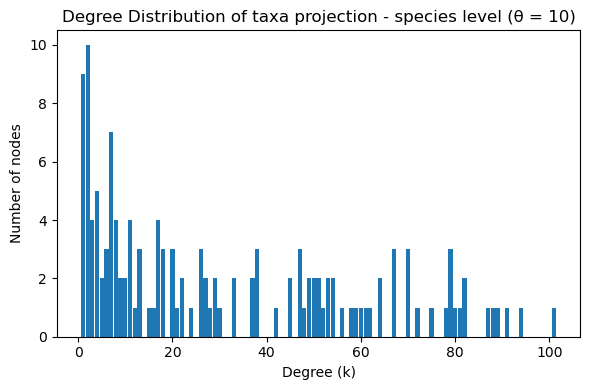

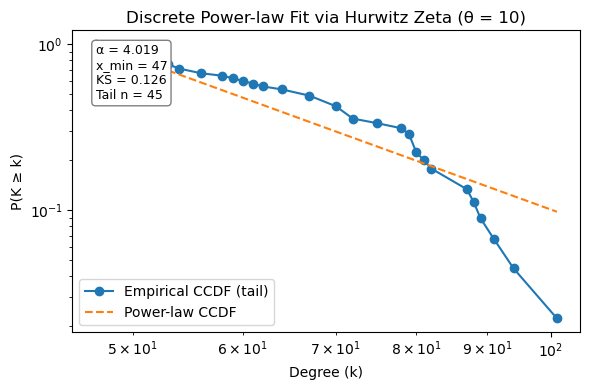

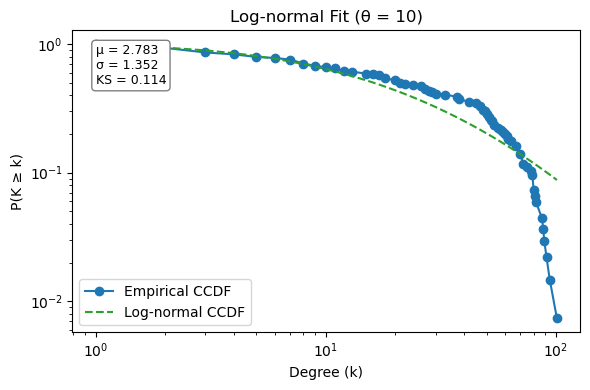

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite
import scipy.stats as sps
from scipy.optimize import minimize_scalar
from mpmath import zeta as mpzeta
import warnings
warnings.filterwarnings("ignore")

# === Helper: Empirical CCDF ===
def empirical_ccdf(data):
    data = np.sort(np.asarray(data))
    vals, counts = np.unique(data, return_counts=True)
    ccdf = counts[::-1].cumsum()[::-1] / len(data)
    return vals, ccdf

# === Helper: Discrete power-law CCDF model ===
def discrete_ccdf_model(xs, xmin, alpha):
    xs = np.array(xs, dtype=int)
    denom = float(mpzeta(alpha, xmin))
    numer = np.array([float(mpzeta(alpha, x)) for x in xs])
    return numer / denom

# === Helper: Fit discrete power-law to tail ===
def fit_powerlaw_degree_tail_discrete(degrees, xmin_candidates="unique", min_tail_n=20):
    deg = np.array(degrees, dtype=int)
    deg = deg[np.isfinite(deg)]
    deg = deg[deg > 0]
    if deg.size == 0:
        return {"pl_xmin": np.nan, "pl_alpha": np.nan, "pl_ks": np.nan,
                "pl_n_tail": 0, "pl_tail_prop": 0.0}

    n_total = len(deg)
    if xmin_candidates == "unique":
        candidates = np.unique(deg)
    else:
        candidates = np.array(sorted({int(x) for x in xmin_candidates if x > 0}))

    best = {"pl_ks": np.inf}
    for xmin in candidates:
        tail = deg[deg >= xmin]
        if len(tail) < min_tail_n:
            continue

        def _negloglik_discrete(alpha):
            if alpha <= 1.0:
                return np.inf
            z = float(mpzeta(alpha, xmin))
            return len(tail) * np.log(z) + alpha * np.sum(np.log(tail))

        res = minimize_scalar(_negloglik_discrete, bounds=(1.01, 6.0), method='bounded')
        if not res.success:
            continue

        alpha = res.x
        empirical_cdf = np.array([(tail <= v).sum() for v in np.unique(tail)]) / len(tail)
        model_cdf = [1.0 - (float(mpzeta(alpha, v + 1)) / float(mpzeta(alpha, xmin))) for v in np.unique(tail)]
        ks = np.max(np.abs(empirical_cdf - model_cdf))
        if ks < best["pl_ks"]:
            best.update({
                "pl_xmin": float(xmin),
                "pl_alpha": float(alpha),
                "pl_ks": float(ks),
                "pl_n_tail": len(tail),
                "pl_tail_prop": len(tail) / n_total
            })

    return best

# === Helper: Fit log-normal ===
def fit_lognormal(deg, min_tail_n=20):
    if len(deg) < min_tail_n:
        return None
    sigma, loc, scale = sps.lognorm.fit(deg, floc=0)
    mu = np.log(scale)
    xs = np.sort(deg)
    emp_cdf = np.arange(1, len(xs)+1) / len(xs)
    mod_cdf = sps.lognorm.cdf(xs, s=sigma, loc=loc, scale=scale)
    ks = np.max(np.abs(emp_cdf - mod_cdf))
    return {"mu": mu, "sigma": sigma, "ks": ks}

# === STEP 1: Taxa–taxa projection ===
theta = 10
taxa_nodes = {n for n, t in B_species.nodes(data=True) if t.get("bipartite") == 1}
G = bipartite.weighted_projected_graph(B_species, taxa_nodes)

# === STEP 2: Thresholding ===
G_thresh = G.copy()
G_thresh.remove_edges_from([(u, v) for u, v, t in G_thresh.edges(data=True) if t["weight"] < theta])
G_thresh.remove_nodes_from([n for n, d in G_thresh.degree() if d == 0])

# === STEP 3: Degree list ===
degrees = np.array([deg for _, deg in G_thresh.degree()], dtype=int)
deg = degrees[degrees > 0]

# === STEP 4: Power-law Fit ===
pl = fit_powerlaw_degree_tail_discrete(deg)
xmin = int(round(pl["pl_xmin"]))
alpha = pl["pl_alpha"]
tail = deg[deg >= xmin]
xs_emp, ccdf_emp = empirical_ccdf(tail)
ccdf_pl = discrete_ccdf_model(xs_emp, xmin, alpha)

# === STEP 5: Log-normal Fit ===
ln = fit_lognormal(deg)
if ln is None:
    raise ValueError("Not enough data points to fit log-normal.")
mu, sigma, ks_ln = ln["mu"], ln["sigma"], ln["ks"]

# === STEP 6: Plot degree histogram ===
vals, counts = np.unique(deg, return_counts=True)
plt.figure(figsize=(6, 4))
plt.bar(vals, counts, width=0.9, align="center")
plt.xlabel("Degree (k)")
plt.ylabel("Number of nodes")
plt.title(f"Degree Distribution of taxa projection - species level (θ = {theta})")
plt.tight_layout()
plt.show()

# === STEP 7: Power-law CCDF plot ===
plt.figure(figsize=(6, 4))
plt.loglog(xs_emp, ccdf_emp, 'o-', label="Empirical CCDF (tail)", color='tab:blue')
plt.loglog(xs_emp, ccdf_pl, '--', label=f"Power-law CCDF", color='tab:orange')

txt = f"α = {alpha:.3f}\nx_min = {xmin}\nKS = {pl['pl_ks']:.3f}\nTail n = {pl['pl_n_tail']}"
plt.text(xs_emp.min(), ccdf_emp.max(), txt, ha='left', va='top', fontsize=9,
         bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

plt.xlabel("Degree (k)")
plt.ylabel("P(K ≥ k)")
plt.title(f"Discrete Power-law Fit via Hurwitz Zeta (θ = {theta})")
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

# === STEP 8: Log-normal CCDF plot ===
x_vals, ccdf_emp_ln = empirical_ccdf(deg)
ccdf_ln = 1.0 - sps.lognorm.cdf(x_vals, s=sigma, loc=0, scale=np.exp(mu))

plt.figure(figsize=(6, 4))
plt.loglog(x_vals, ccdf_emp_ln, 'o-', label='Empirical CCDF', color='tab:blue')
plt.loglog(x_vals, ccdf_ln, '--', label='Log-normal CCDF', color='tab:green')

txt_ln = f"μ = {mu:.3f}\nσ = {sigma:.3f}\nKS = {ks_ln:.3f}"
plt.text(x_vals.min(), ccdf_emp_ln.max(), txt_ln, ha='left', va='top', fontsize=9,
         bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

plt.xlabel("Degree (k)")
plt.ylabel("P(K ≥ k)")
plt.title(f"Log-normal Fit (θ = {theta})")
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()


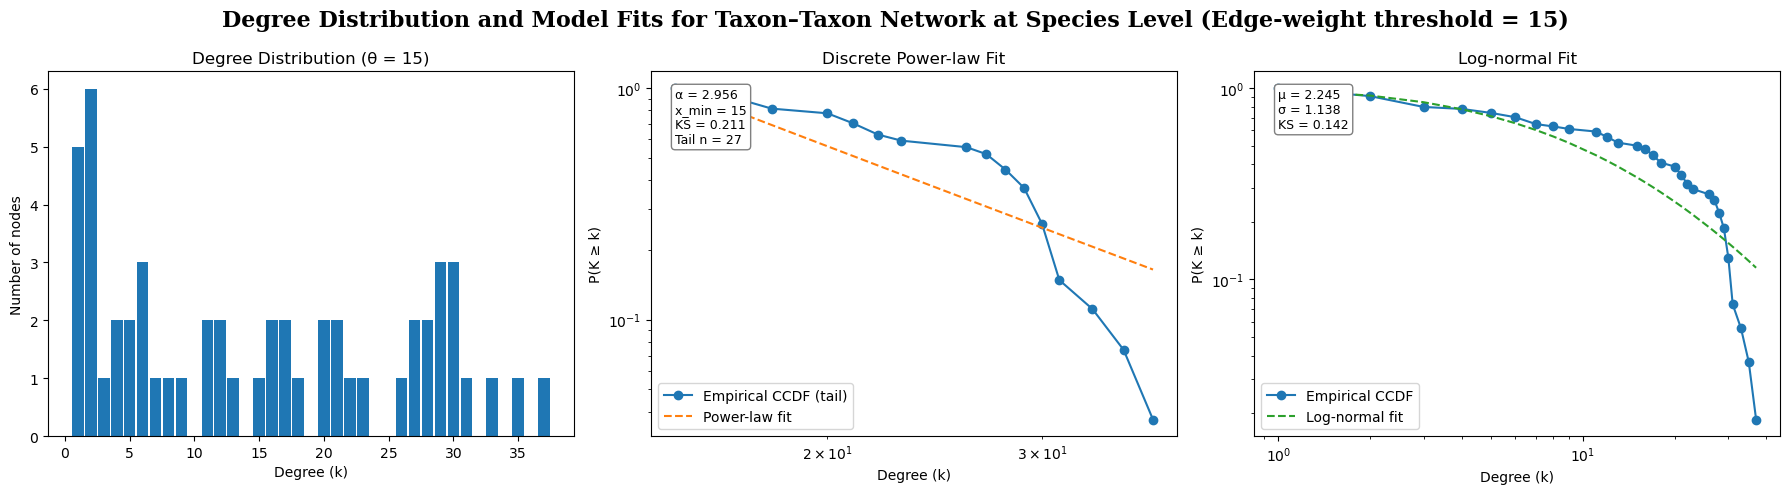

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite
import scipy.stats as sps
from scipy.optimize import minimize_scalar
from mpmath import zeta as mpzeta
import warnings
warnings.filterwarnings("ignore")

# === Helper: Empirical CCDF ===
def empirical_ccdf(data):
    data = np.sort(np.asarray(data))
    vals, counts = np.unique(data, return_counts=True)
    ccdf = counts[::-1].cumsum()[::-1] / len(data)
    return vals, ccdf

# === Helper: Discrete power-law CCDF model ===
def discrete_ccdf_model(xs, xmin, alpha):
    xs = np.array(xs, dtype=int)
    denom = float(mpzeta(alpha, xmin))
    numer = np.array([float(mpzeta(alpha, x)) for x in xs])
    return numer / denom

# === Helper: Fit discrete power-law to tail ===
def fit_powerlaw_degree_tail_discrete(degrees, xmin_candidates="unique", min_tail_n=20):
    deg = np.array(degrees, dtype=int)
    deg = deg[np.isfinite(deg)]
    deg = deg[deg > 0]
    if deg.size == 0:
        return {"pl_xmin": np.nan, "pl_alpha": np.nan, "pl_ks": np.nan,
                "pl_n_tail": 0, "pl_tail_prop": 0.0}
    n_total = len(deg)
    if xmin_candidates == "unique":
        candidates = np.unique(deg)
    else:
        candidates = np.array(sorted({int(x) for x in xmin_candidates if x > 0}))
    best = {"pl_ks": np.inf}
    for xmin in candidates:
        tail = deg[deg >= xmin]
        if len(tail) < min_tail_n:
            continue
        def _negloglik_discrete(alpha):
            if alpha <= 1.0:
                return np.inf
            z = float(mpzeta(alpha, xmin))
            return len(tail) * np.log(z) + alpha * np.sum(np.log(tail))
        res = minimize_scalar(_negloglik_discrete, bounds=(1.01, 6.0), method='bounded')
        if not res.success:
            continue
        alpha = res.x
        empirical_cdf = np.array([(tail <= v).sum() for v in np.unique(tail)]) / len(tail)
        model_cdf = [1.0 - (float(mpzeta(alpha, v + 1)) / float(mpzeta(alpha, xmin))) for v in np.unique(tail)]
        ks = np.max(np.abs(empirical_cdf - model_cdf))
        if ks < best["pl_ks"]:
            best.update({
                "pl_xmin": float(xmin),
                "pl_alpha": float(alpha),
                "pl_ks": float(ks),
                "pl_n_tail": len(tail),
                "pl_tail_prop": len(tail) / n_total
            })
    return best

# === Helper: Fit log-normal ===
def fit_lognormal(deg, min_tail_n=20):
    if len(deg) < min_tail_n:
        return None
    sigma, loc, scale = sps.lognorm.fit(deg, floc=0)
    mu = np.log(scale)
    xs = np.sort(deg)
    emp_cdf = np.arange(1, len(xs)+1) / len(xs)
    mod_cdf = sps.lognorm.cdf(xs, s=sigma, loc=loc, scale=scale)
    ks = np.max(np.abs(emp_cdf - mod_cdf))
    return {"mu": mu, "sigma": sigma, "ks": ks}

# === STEP 1: taxa–taxa projection ===
theta = 15
taxa_nodes = {n for n, t in B_species.nodes(data=True) if t.get("bipartite") == 1}
G = bipartite.weighted_projected_graph(B_species, taxa_nodes)

# === STEP 2: Thresholding ===
G_thresh = G.copy()
G_thresh.remove_edges_from([(u, v) for u, v, ed in G_thresh.edges(data=True) if ed["weight"] < theta])

# Remove isolates (degree == 0), not degree == 1
G_thresh.remove_nodes_from([n for n, deg in G_thresh.degree() if deg == 0])


# === STEP 3: Degree list ===
degrees = np.array([deg for _, deg in G_thresh.degree()], dtype=int)
deg = degrees[degrees > 0]

# === STEP 4: Power-law Fit ===
pl = fit_powerlaw_degree_tail_discrete(deg)
xmin = int(round(pl["pl_xmin"]))
alpha = pl["pl_alpha"]
tail = deg[deg >= xmin]
xs_emp_pl, ccdf_emp_pl = empirical_ccdf(tail)
ccdf_pl = discrete_ccdf_model(xs_emp_pl, xmin, alpha)

# === STEP 5: Log-normal Fit ===
ln = fit_lognormal(deg)
if ln is None:
    raise ValueError("Not enough data points to fit log-normal.")
mu, sigma, ks_ln = ln["mu"], ln["sigma"], ln["ks"]
xs_emp_ln, ccdf_emp_ln = empirical_ccdf(deg)
ccdf_ln = 1.0 - sps.lognorm.cdf(xs_emp_ln, s=sigma, loc=0, scale=np.exp(mu))

# === STEP 6: Plot all in one canvas ===

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle(
    f"Degree Distribution and Model Fits for Taxon–Taxon Network at Species Level (Edge-weight threshold = {theta})",
    fontsize=16, fontweight='bold', fontfamily='serif'
)

# --- Subplot 1: Degree histogram ---
vals, counts = np.unique(deg, return_counts=True)
axes[0].bar(vals, counts, width=0.9, align="center")
axes[0].set_xlabel("Degree (k)")
axes[0].set_ylabel("Number of nodes")
axes[0].set_title(f"Degree Distribution (θ = {theta})")

# --- Subplot 2: Power-law CCDF (tail only) ---
axes[1].loglog(xs_emp_pl, ccdf_emp_pl, 'o-', color='tab:blue', label="Empirical CCDF (tail)")
axes[1].loglog(xs_emp_pl, ccdf_pl, '--', color='tab:orange', label="Power-law fit")
axes[1].set_xlabel("Degree (k)")
axes[1].set_ylabel("P(K ≥ k)")
axes[1].set_title("Discrete Power-law Fit")
txt_pl = f"α = {alpha:.3f}\nx_min = {xmin}\nKS = {pl['pl_ks']:.3f}\nTail n = {pl['pl_n_tail']}"
axes[1].text(xs_emp_pl.min(), ccdf_emp_pl.max(), txt_pl,
             ha='left', va='top', fontsize=9,
             bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))
axes[1].legend(loc='lower left')

# --- Subplot 3: Log-normal CCDF (full) ---
axes[2].loglog(xs_emp_ln, ccdf_emp_ln, 'o-', color='tab:blue', label="Empirical CCDF")
axes[2].loglog(xs_emp_ln, ccdf_ln, '--', color='tab:green', label="Log-normal fit")
axes[2].set_xlabel("Degree (k)")
axes[2].set_ylabel("P(K ≥ k)")
axes[2].set_title("Log-normal Fit")
txt_ln = f"μ = {mu:.3f}\nσ = {sigma:.3f}\nKS = {ks_ln:.3f}"
axes[2].text(xs_emp_ln.min(), ccdf_emp_ln.max(), txt_ln,
             ha='left', va='top', fontsize=9,
             bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))
axes[2].legend(loc='lower left')

plt.tight_layout()
plt.show()
